In [1]:
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from statsmodels.stats.multitest import multipletests
from pathlib import Path
from tqdm.auto import tqdm
import re
import glob
from scipy import stats

In [6]:
def summarize_exp_stats(lane_path, lane_list):
    dfs = []  
    for lanes in lane_list:
        df = pd.read_csv(glob.glob(os.path.join(lane_path, lanes, "*_guide_count_info.csv"))[0])
        df.set_index('guide_id', inplace= True)
        dfs.append(df)
    num_cols = ['n_cells','sum_guide','sumsq_guide','ntc_cells','sum_ntc','sumsq_ntc']
    
    summary_ = pd.concat([df[num_cols] for df in dfs], axis=0).groupby('guide_id').sum()
    return summary_

In [2]:
def compute_stats_ko(df):
    pseudocount = 5e-2

    # Means
    df["guide_mean"] = df["sum_guide"] / df["n_cells"]
    df["ntc_mean"]   = df["sum_ntc"]   / df["ntc_cells"]

    # Variances (safe when n>=2)
    df["guide_var"] = (df["sumsq_guide"] - (df["sum_guide"]**2)/df["n_cells"]) / (df["n_cells"] - 1)
    df["ntc_var"]   = (df["sumsq_ntc"]   - (df["sum_ntc"]**2)/df["ntc_cells"]) / (df["ntc_cells"] - 1)

    df["guide_std"] = np.sqrt(df["guide_var"])
    df["ntc_std"]   = np.sqrt(df["ntc_var"])

    # Handle NaN/0 std
    df.fillna({'guide_std': 0, 'ntc_std': 0}, inplace=True)
    df.loc[:, "guide_std"] = np.where(df["guide_std"] == 0, 0.01, df["guide_std"])
    df.loc[:, "ntc_std"]   = np.where(df["ntc_std"]   == 0, 0.01, df["ntc_std"])

    # Decide direction
    
    # Fold-change definition (do once)
    df["fc"] = (df["ntc_mean"] + pseudocount) / (df["guide_mean"] + pseudocount)  # >1 means knockdown

    # Welch t-test per row
    t_stats, p_ones = [], []
    for _, row in df.iterrows():
        t_stat, p_two = stats.ttest_ind_from_stats(
            row["guide_mean"], row["guide_std"], row["n_cells"],
            row["ntc_mean"],   row["ntc_std"],   row["ntc_cells"],
            equal_var=False
        )
            
        if (t_stat < 0):
            p_one = (p_two / 2) 
        else:
            p_one = 1.0

        t_stats.append(t_stat)
        p_ones.append(p_one)

    df["t_statistic"] = t_stats
    df["p_value"] = p_ones

    # FDR
    mask = df["p_value"].notna()
    df["adj_pvals"] = np.nan
    df.loc[mask, "adj_pvals"] = multipletests(df.loc[mask, "p_value"], method="fdr_bh")[1]

    # Cohen's d (pooled SD)
    n1 = df["n_cells"].astype(float)
    n2 = df["ntc_cells"].astype(float)
    sp2 = ((n1 - 1)*df["guide_var"] + (n2 - 1)*df["ntc_var"]) / (n1 + n2 - 2)
    sp  = np.sqrt(sp2)

    df["effect_size"] = np.nan
    m = (n1 >= 2) & (n2 >= 2) & (sp > 0)
    df.loc[m, "effect_size"] = (df.loc[m, "guide_mean"] - df.loc[m, "ntc_mean"]) / sp[m]

    return df

In [3]:
dir_list = pd.read_csv('/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/experiment_info.csv')
lane_cols_for_eff = [c for c in dir_list.columns]
run = []
for _, row in dir_list[lane_cols_for_eff].iterrows():
    for col in lane_cols_for_eff:
       run.append(f'{row[col]}_{col}')

In [4]:
lane_path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/'
ctrl_list = []
lps_list = []
for i in run:
    if 'Ctrl' in i:
        ctrl_list.append(i)
    else:
        lps_list.append(i)

In [7]:
df_ctrl =  summarize_exp_stats(lane_path, ctrl_list)
df_ctrl

,n_cells,sum_guide,sumsq_guide,ntc_cells,sum_ntc,sumsq_ntc
guide_id,,,,,,
A4GALT-1,578,17.812806,15.402874,29628,564.380737,477.377357
A4GALT-2,390,13.338955,10.076600,29628,564.380737,477.377357
A4GALT-3,827,23.268857,18.793370,29628,564.380737,477.377357
A4GALT-4,951,19.837996,16.570582,29628,564.380737,477.377357
AAGAB-1,844,369.662735,363.413429,29628,17444.345459,18807.167725
...,...,...,...,...,...,...
ZNF79-4,645,19.992992,13.534191,29628,1139.320648,881.889221
ZNF823-1,750,47.474886,39.372021,29628,2265.794250,1867.140106
ZNF823-2,719,65.517632,47.691523,29628,2265.794250,1867.140106


In [8]:
df_lps = summarize_exp_stats(lane_path, lps_list)
df_lps

,n_cells,sum_guide,sumsq_guide,ntc_cells,sum_ntc,sumsq_ntc
guide_id,,,,,,
A4GALT-1,684,129.025307,121.841091,33146,7415.184814,7427.030273
A4GALT-2,416,83.572794,83.632089,33146,7415.184814,7427.030273
A4GALT-3,1060,248.192352,243.806694,33146,7415.184814,7427.030273
A4GALT-4,1135,225.813587,219.349014,33146,7415.184814,7427.030273
AAGAB-1,893,437.408257,450.637596,33146,21135.842285,23689.932129
...,...,...,...,...,...,...
ZNF79-4,818,19.905251,14.135347,33146,1104.591644,864.881454
ZNF823-1,910,33.340771,27.321822,33146,1333.877625,1084.952240
ZNF823-2,905,45.083932,37.499981,33146,1333.877625,1084.952240


In [9]:
path_fdr = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/qc_stats'
df_ctrl_fdr = compute_stats_ko(df_ctrl)
df_lps_fdr = compute_stats_ko(df_lps)

# Cell level guide efficiency

In [10]:
df_ctrl = []
df_lps = []
for i in run:
    cell_ko_pattern = glob.glob(os.path.join('/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis', i, '*cells_based_guide_efficiency.csv'))[0]
    df = pd.read_csv(cell_ko_pattern)
    if 'Ctrl' in i:
        df_ctrl.append(df)
    else:
        df_lps.append(df)

In [11]:
dfs_ctrl = pd.concat(df_ctrl,axis=0)
dfs_lps = pd.concat(df_lps,axis=0)
dfs_ctrl['signif_ko_95perc'] = dfs_ctrl['ntc_fraction'] < 0.05
dfs_lps['signif_ko_95perc'] = dfs_lps['ntc_fraction'] < 0.05

In [12]:
def ko_cells_percent(df):
    n_kos = df.groupby('guide_id')['signif_ko_95perc'].sum()
    n_tot = df.groupby('guide_id').size()
    df_ko = pd.DataFrame(n_kos/n_tot, columns= ['percent_cells_signi_ko'])
    df_ko
    return df_ko

In [13]:
df_ctrl_ko = ko_cells_percent(dfs_ctrl)
df_lps_ko = ko_cells_percent(dfs_lps)

In [14]:
df_ctrl_fdr =pd.merge(df_ctrl_fdr, df_ctrl_ko, on = 'guide_id', how= 'inner')
df_lps_fdr = pd.merge(df_lps_fdr, df_lps_ko, on = 'guide_id', how= 'inner')

In [15]:
df_ctrl_fdr

,n_cells,sum_guide,sumsq_guide,ntc_cells,sum_ntc,sumsq_ntc,guide_mean,ntc_mean,guide_var,ntc_var,guide_std,ntc_std,fc,t_statistic,p_value,adj_pvals,effect_size,percent_cells_signi_ko
guide_id,,,,,,,,,,,,,,,,,,
A4GALT-1,578,17.812806,15.402874,29628,564.380737,477.377357,0.030818,0.019049,0.025743,0.015750,0.160447,0.125499,0.854375,1.753066,1.000000e+00,1.000000e+00,0.093215,0.958478
A4GALT-2,390,13.338955,10.076600,29628,564.380737,477.377357,0.034202,0.019049,0.024731,0.015750,0.157261,0.125499,0.820034,1.895015,1.000000e+00,1.000000e+00,0.120303,0.948718
A4GALT-3,827,23.268857,18.793370,29628,564.380737,477.377357,0.028136,0.019049,0.021960,0.015750,0.148188,0.125499,0.883696,1.746158,1.000000e+00,1.000000e+00,0.072027,0.961306
A4GALT-4,951,19.837996,16.570582,29628,564.380737,477.377357,0.020860,0.019049,0.017007,0.015750,0.130411,0.125499,0.974439,0.422077,1.000000e+00,1.000000e+00,0.014414,0.972660
AAGAB-1,844,369.662735,363.413429,29628,17444.345459,18807.167725,0.437989,0.588779,0.239033,0.288126,0.488910,0.536773,1.309003,-8.810152,3.160953e-18,1.579748e-17,-0.281584,0.490521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF79-4,645,19.992992,13.534191,29628,1139.320648,881.889221,0.030997,0.038454,0.020054,0.028288,0.141610,0.168189,1.092069,-1.317341,9.408275e-02,1.469154e-01,-0.044477,0.950388
ZNF823-1,750,47.474886,39.372021,29628,2265.794250,1867.140106,0.063300,0.076475,0.048554,0.057173,0.220349,0.239109,1.116284,-1.613572,5.350874e-02,8.687160e-02,-0.055203,0.912000
ZNF823-2,719,65.517632,47.691523,29628,2265.794250,1867.140106,0.091123,0.076475,0.058108,0.057173,0.241055,0.239109,0.896201,1.610338,1.000000e+00,1.000000e+00,0.061251,0.862309


In [16]:
df_ctrl_fdr.to_csv(os.path.join(path_fdr, 'Macs_Ctrl_cell_level_guide_efficiency.csv'))
df_lps_fdr.to_csv(os.path.join(path_fdr, 'Macs_LPS_cell_level_guide_efficiency.csv'))

In [28]:
dfs= {'Macs Ctrl': df_ctrl_fdr.reset_index(), 'Macs LPS': df_lps_fdr.reset_index()}

In [29]:
def find_signi_ko(df):
    df['target_gene'] = df['guide_id'].str.replace('-', '_').str.split('_').str[0]
    df['signif_knockdown'] = df['adj_pvals'] < 0.1
    return df

In [30]:
for k, v in dfs.items():
    find_signi_ko(v)
    gene_ntc_means = v.groupby('target_gene')['ntc_mean'].mean()

    # Rank the perturbed genes by their mean NTC expression, using method='first' to handle ties
    gene_ranks = gene_ntc_means.rank(method='first')

    v['rank'] = v['target_gene'].map(gene_ranks)

    # Calculate fraction of significant knockdowns and mean expression in bins of 100 ranks
    v['rank_bin'] = pd.qcut(v['rank'], q=len(v)//100, labels=False)

    # For more than 50% cells having significant Ko
    v['percent_cells_signi_ko'] = v['percent_cells_signi_ko'] * 100

    # For the difference between guide mean expression and ntc mean expression for the target gene
    v["delta"] = v["guide_mean"] - v["ntc_mean"]

In [33]:
bin_stat_dfs = {}

for k, v in dfs.items():
    bin_stats = v.groupby('rank_bin').agg({
    'rank': 'mean', 
    'signif_knockdown': 'mean', 
    'guide_mean': 'mean',
    'ntc_mean': 'mean',
    'n_cells': 'mean',
    'target_gene': 'nunique'
    }).reset_index()

    bin_stat_dfs[k] = bin_stats

In [27]:
def guide_effect_scatter_plot(df, sample_name):
    name = ' '.join(sample_name.split('_')[:2])

    d = df.copy()

    # Use explicit legend keys (strings) so we can add the NT line as a 3rd color item
    d["color_key"] = d["signif_knockdown"].map({
        True:  "Mean expression cells with targeting guide with significant KD (FDR < 10%)",
        False: "Mean expression cells with targeting guide with non-significant KD (FDR ≥ 10%)",
    })

    NT_LINE_KEY = "Mean expression for NT guide"
    NT_RIBBON_KEY = "Mean expression for NT guide"

    p = (
        ggplot(d, aes(x="rank", y="guide_mean", color="color_key"))
        + geom_point(alpha=0.6)

        # Map the NT mean line to color so it appears in the SAME legend (as grey)
        + geom_line(
            data=d.sort_values("rank"),
            mapping=aes(x="rank", y="ntc_mean", color=f'"{NT_LINE_KEY}"'),
            alpha=0.8,
            inherit_aes=False
        )

        # Ribbon stays in fill legend
        + geom_ribbon(
            data=d.sort_values("rank"),
            mapping=aes(
                x="rank",
                ymin=0,
                ymax="ntc_mean + ntc_std",
                fill=f'"{NT_RIBBON_KEY}"'
            ),
            alpha=0.2,
            inherit_aes=False
        )

        + scale_color_manual(
            values={
                "Mean expression cells with targeting guide with significant KD (FDR < 10%)": "red",
                "Mean expression cells with targeting guide with non-significant KD (FDR ≥ 10%)": "blue",
                NT_LINE_KEY: "grey",
            },
            breaks=[
                "Mean expression cells with targeting guide with significant KD (FDR < 10%)",
                "Mean expression cells with targeting guide with non-significant KD (FDR ≥ 10%)"
            ],
        )
        + scale_fill_manual(
            values={NT_RIBBON_KEY: "grey"},
            breaks=[NT_RIBBON_KEY],
        )

        + labs(
            title=name,
            y="Perturbed gene mean expression\n(log-normalized expression)",
            x="Gene rank (perturbed)"
        )

        + theme_bw()
        + theme(
            legend_position="bottom",
            legend_title=element_blank(),

            # Stack color + fill legends so long text doesn't collide
            legend_box="vertical",
            legend_box_just="left",

            legend_text=element_text(size=12),

            # Give legend keys a bit more room; don’t shrink legend content
            legend_key_size=10,

            plot_title=element_text(size=16, face="bold"),
            axis_title_x=element_text(size=18),
            axis_title_y=element_text(size=18),
            axis_text_x=element_text(size=12),
            axis_text_y=element_text(size=12),
        )

        # Each item on its own row (keeps your long labels readable)
        + guides(
            color=guide_legend(nrow=3, byrow=True),
            fill=guide_legend(nrow=1, byrow=True),
        )
    )

    return p

In [31]:
def cell_guide_efficiency(df, sample_name):
    p = (
        ggplot()

        # 🔹 Non-significant = black dots
        + geom_point(
            df[df["signif_knockdown"] == False],
            aes(x="rank", y="delta"),
            color="black",
            size=1.2,
            alpha=0.7
        )

        # 🔹 Significant = colored by % KO
        + geom_point(
            df[df["signif_knockdown"] == True],
            aes(x="rank", y="delta", color="percent_cells_signi_ko"),
            size=2.5,
            alpha=0.9
        )

        + geom_hline(yintercept=0, alpha=0.4)

        + scale_color_gradient2(
            low="blue",
            mid="yellow",
            high="red",
            midpoint=50,
            name="% cells with significant KO"
        )

        + labs(
            title=sample_name,
            y="Δ expression mean \n (targeting − non-targeting)",
            x="Gene rank"
        )

        + theme_bw()
        + theme(
            plot_title = element_text(size = 16, face = "bold"),
            axis_title_x = element_text(size = 18),
            axis_title_y = element_text(size = 18),
            axis_text_x = element_text(size = 12), # Size of tick labels
            axis_text_y = element_text(size = 12)  # Size of tick labels
              )
        + theme(
            legend_title = element_text(size = 14),
            legend_text = element_text(size = 12)
              )
    )

    return p


In [32]:
def rank_bin_effi(df, sample_name):
    p = (
        ggplot(df, aes(x='rank', y='signif_knockdown'))
        + geom_point(color='black')
        + labs(
            title=f"{sample_name}\nMean target gene expression\n(log-normalized counts)",
            y='Significant Knockdown',
            x='Rank'
        )
        + theme_bw()
        + theme(
            plot_title=element_text(size=16, face="bold", ha='center'),
            axis_title_x=element_text(size=18),
            axis_title_y=element_text(size=18),
            axis_text_x=element_text(size=12),
            axis_text_y=element_text(size=12)
        )
    )
    return p

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/Macs Ctrl_scatterplot_kd.png


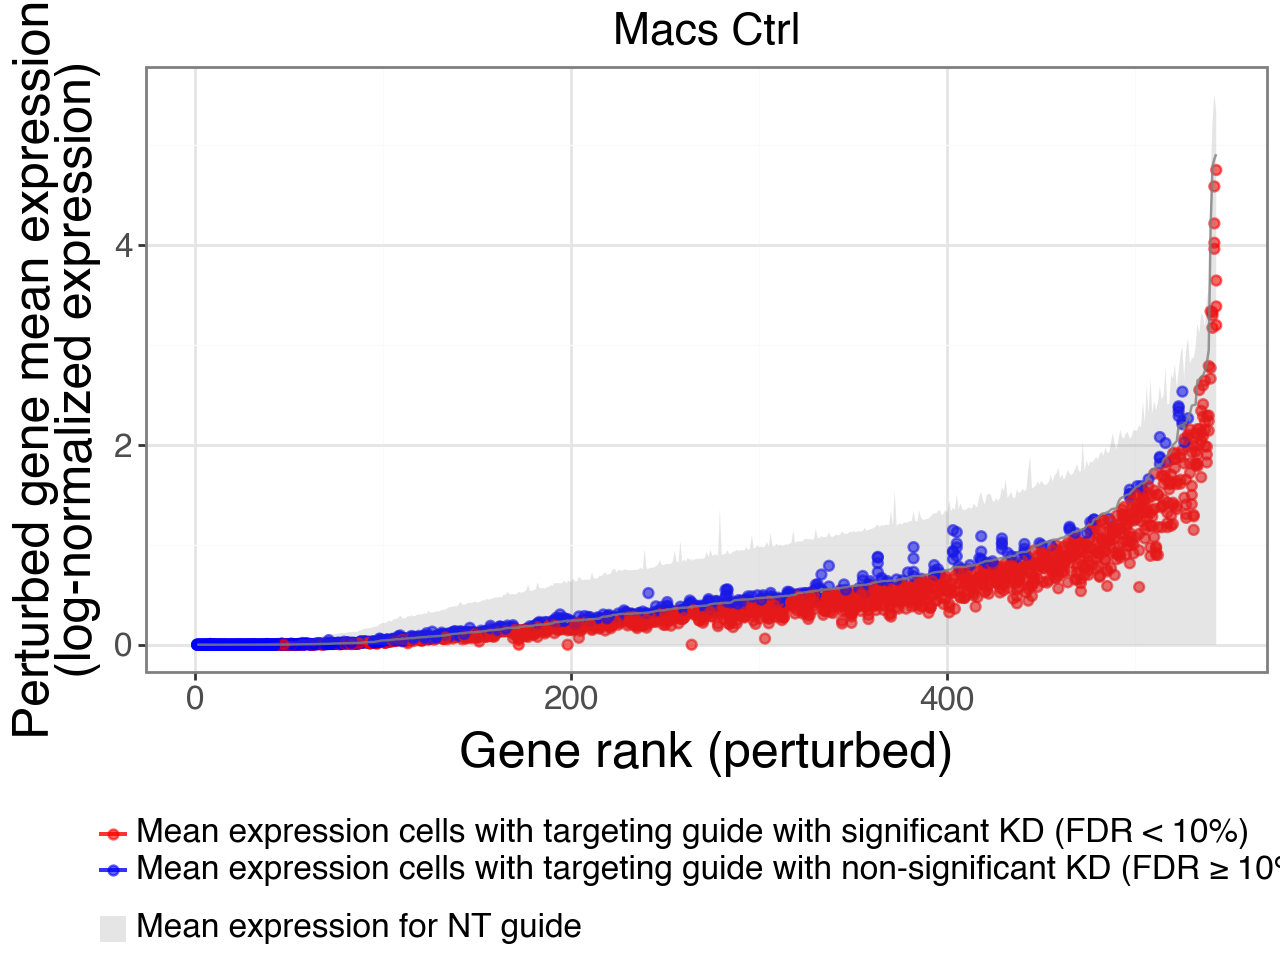

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/Macs LPS_scatterplot_kd.png


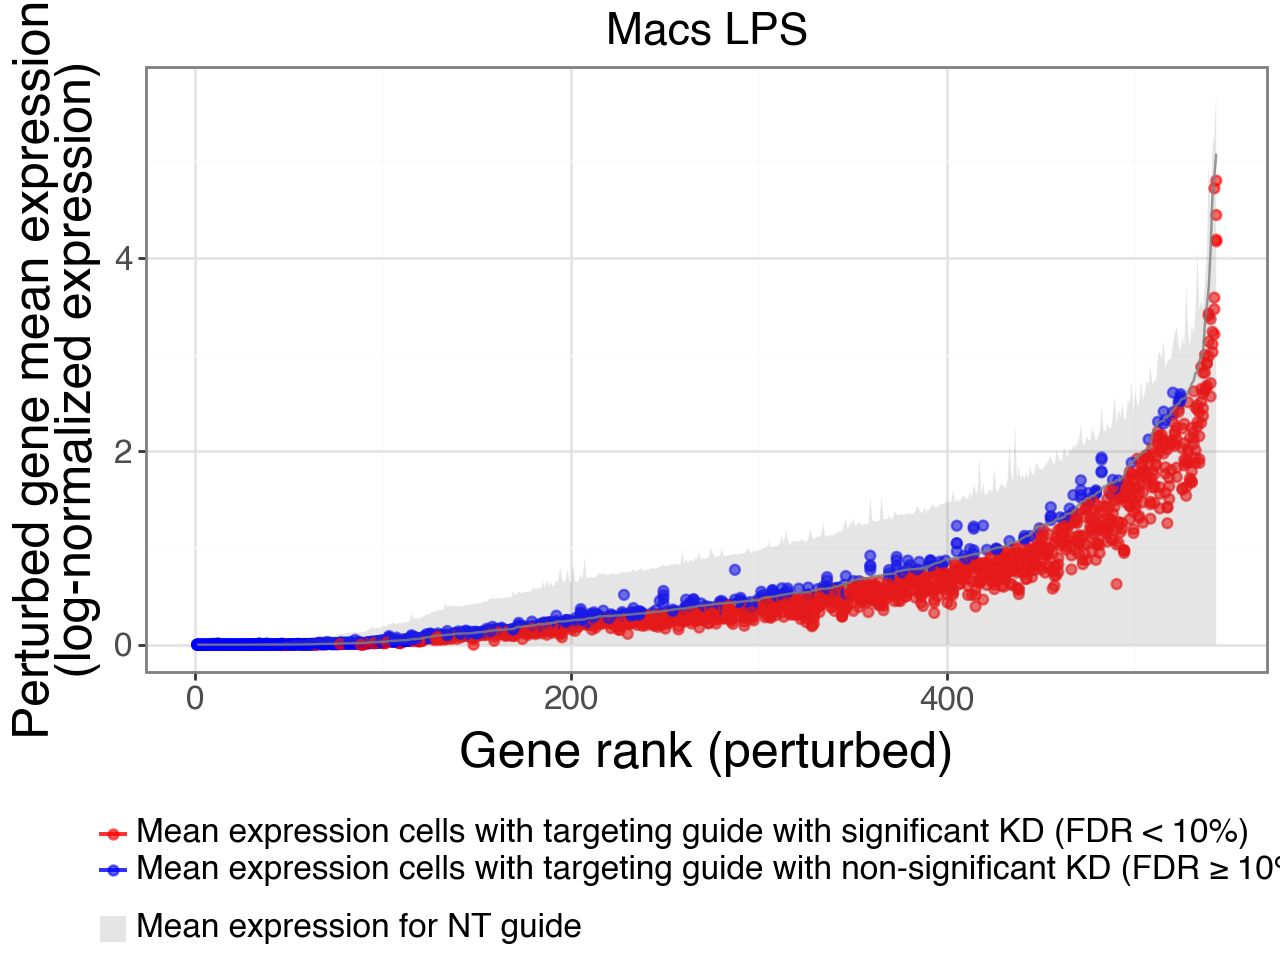

In [35]:
plt_path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots'
for k,v in dfs.items():
    pl_ge = guide_effect_scatter_plot(v, k)
    pl_ge.save(os.path.join(plt_path, f'{k}_scatterplot_kd.png'), dpi = 150)
    pl_ge.show()

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/Macs Ctrl_scatterplot_cell_ko.png


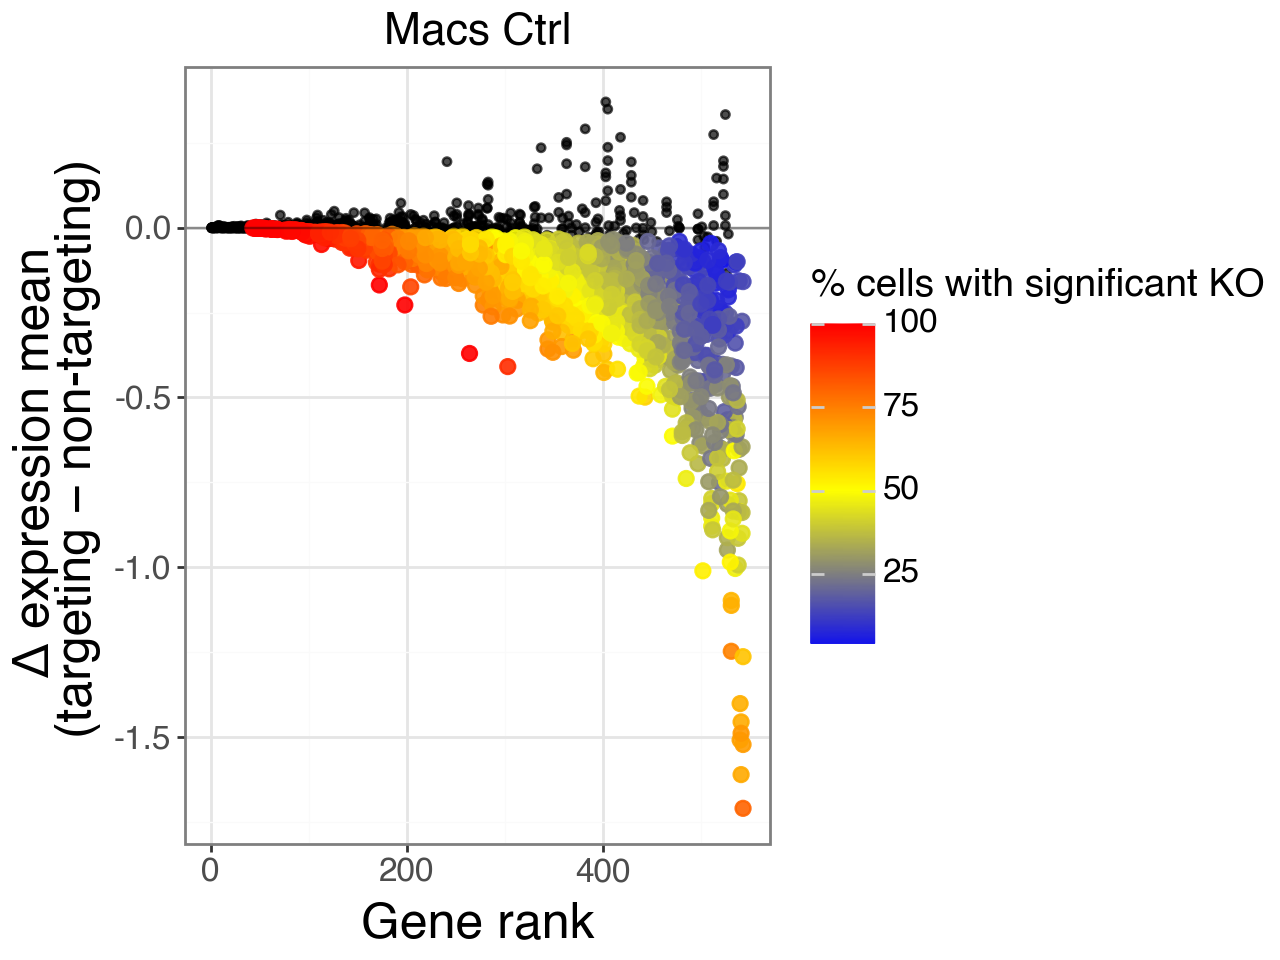

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/Macs LPS_scatterplot_cell_ko.png


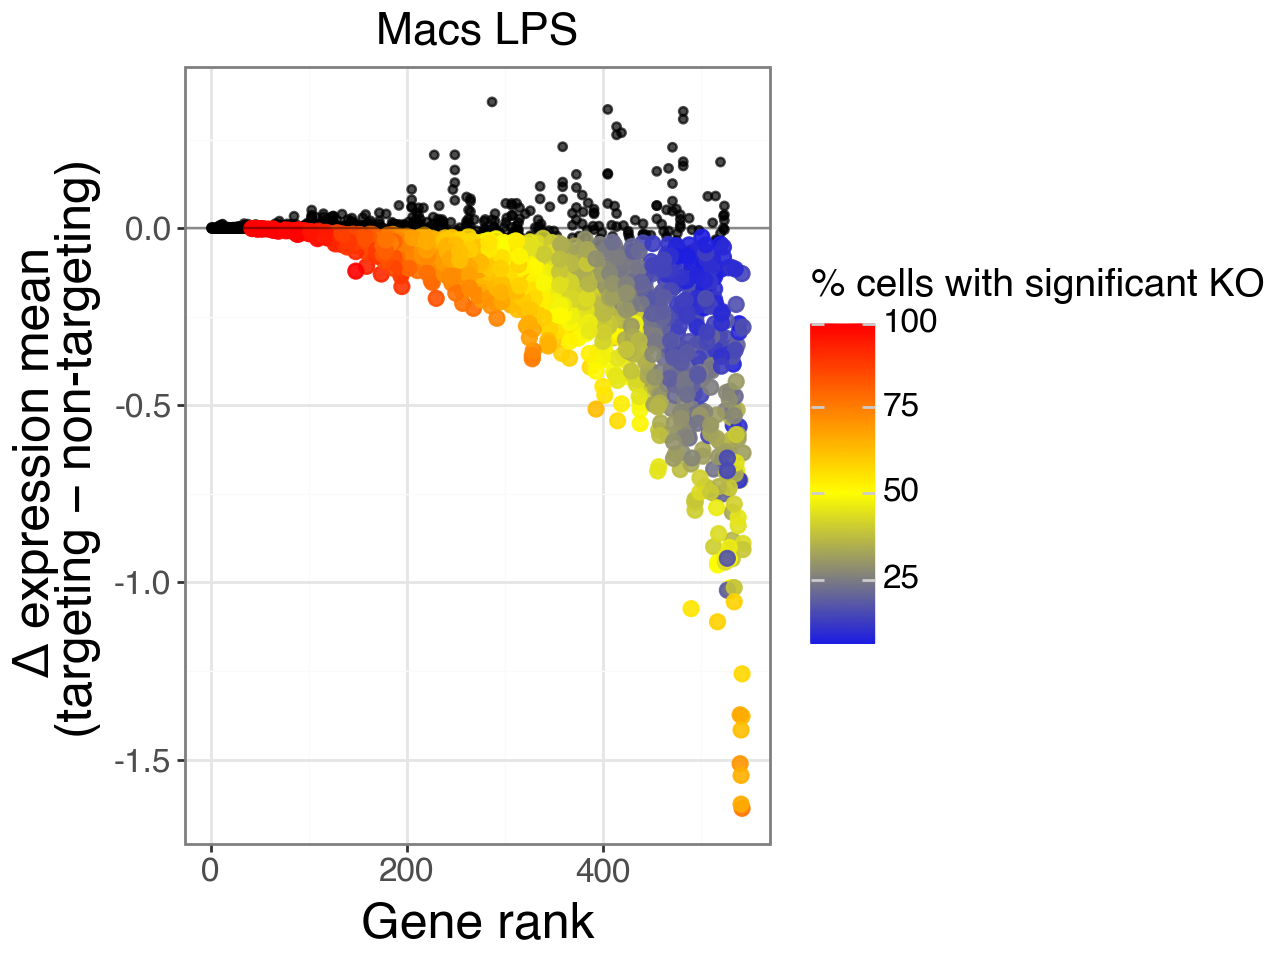

In [36]:
for k,v in dfs.items():
    pl_ge = cell_guide_efficiency(v, k)
    pl_ge.save(os.path.join(plt_path, f'{k}_scatterplot_cell_ko.png'), dpi = 150)
    pl_ge.show()

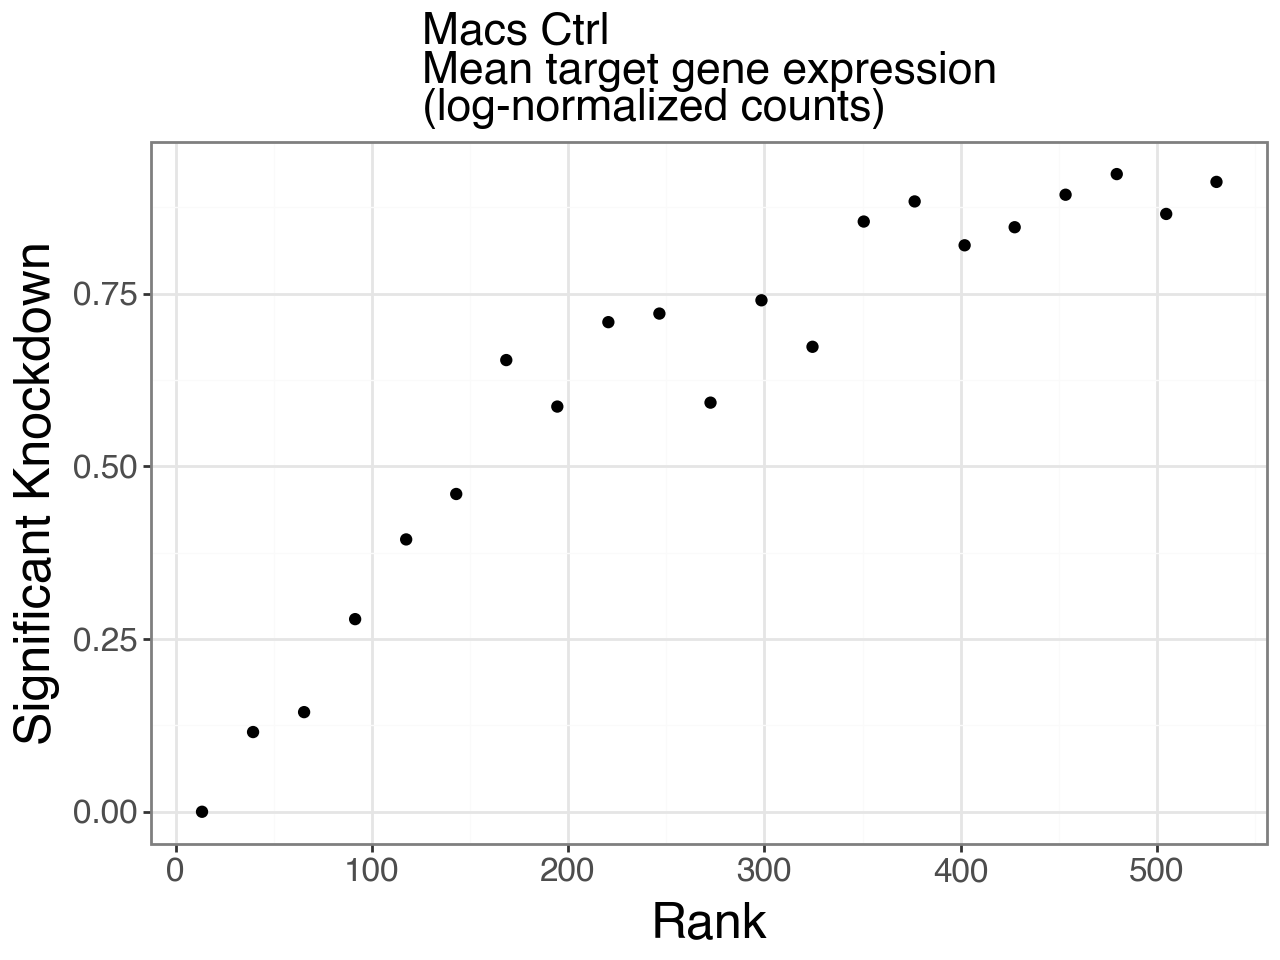

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/Macs Ctrl_mean_target_gene_exp.png


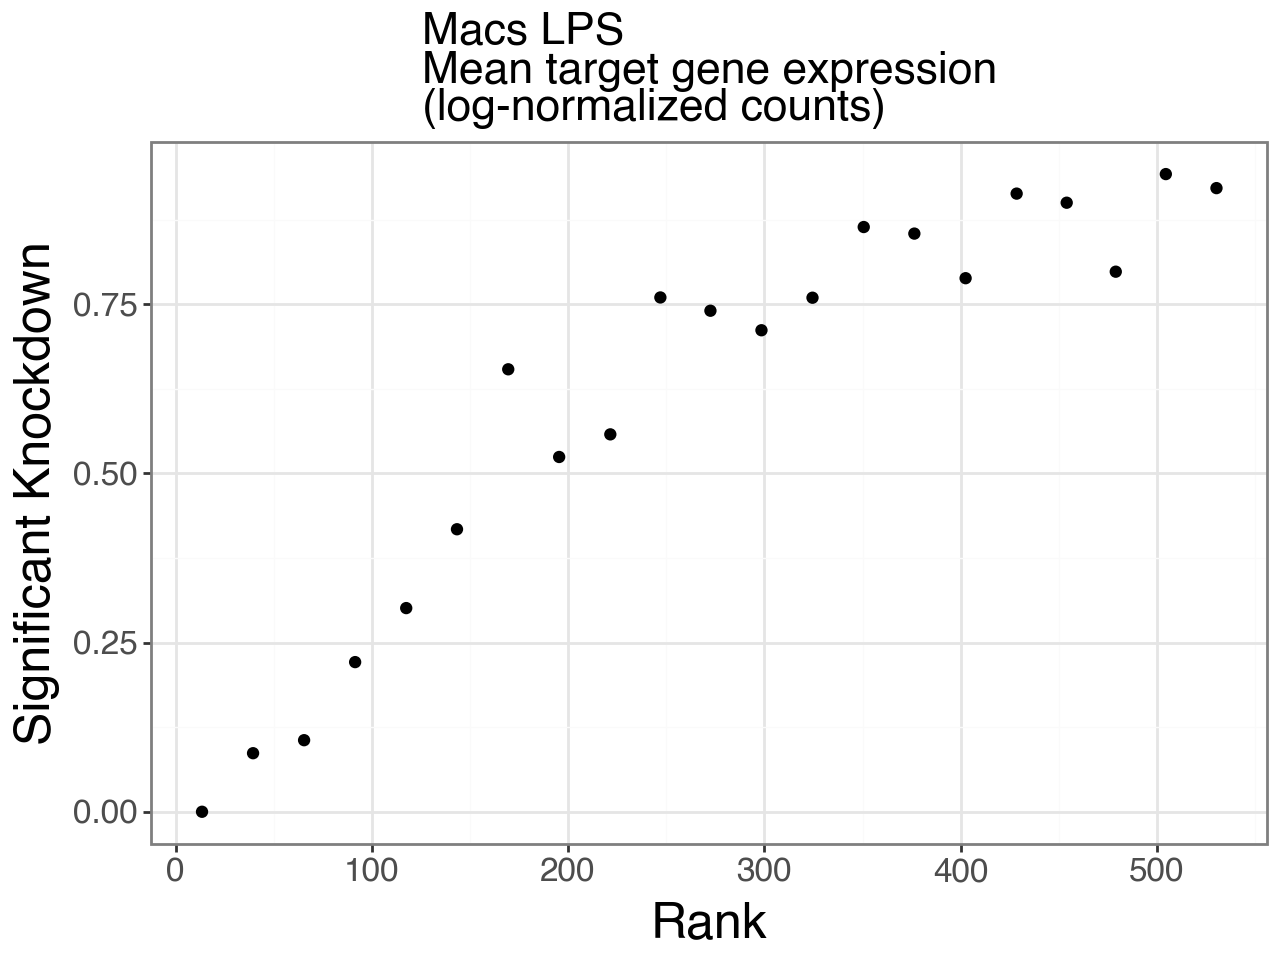

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/Macs LPS_mean_target_gene_exp.png


In [37]:
for k, v in bin_stat_dfs.items():
    p = rank_bin_effi(v, k)
    p.show()
    p.save(os.path.join(plt_path, f'{k}_mean_target_gene_exp.png'), dpi= 150)
    

In [38]:
df= dfs['Macs LPS'][['guide_id','n_cells', 'percent_cells_signi_ko', 'signif_knockdown']]
df['type'] = 'LPS'
df = pd.concat((df, dfs['Macs Ctrl'][['guide_id','n_cells', 'percent_cells_signi_ko', 'signif_knockdown']]), axis= 0 )
df.fillna('Ctrl', inplace= True)
df

/var/folders/lh/8shkr2ln1lz628fhh9nfhqh00000gp/T/ipykernel_53619/2768653971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,guide_id,n_cells,percent_cells_signi_ko,signif_knockdown,type
0,A4GALT-1,684,76.315789,True,LPS
1,A4GALT-2,416,76.201923,False,LPS
2,A4GALT-3,1060,72.358491,False,LPS
3,A4GALT-4,1135,75.594714,True,LPS
4,AAGAB-1,893,46.024636,True,LPS
...,...,...,...,...,...
2164,ZNF79-4,645,95.038760,False,Ctrl
2165,ZNF823-1,750,91.200000,True,Ctrl
2166,ZNF823-2,719,86.230876,False,Ctrl
2167,ZNF823-3,472,90.889831,False,Ctrl


/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/distribution_of_cell_counts_per_guide.png
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 49'. Pick better value with 'binwidth'.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 49'. Pick better value with 'binwidth'.


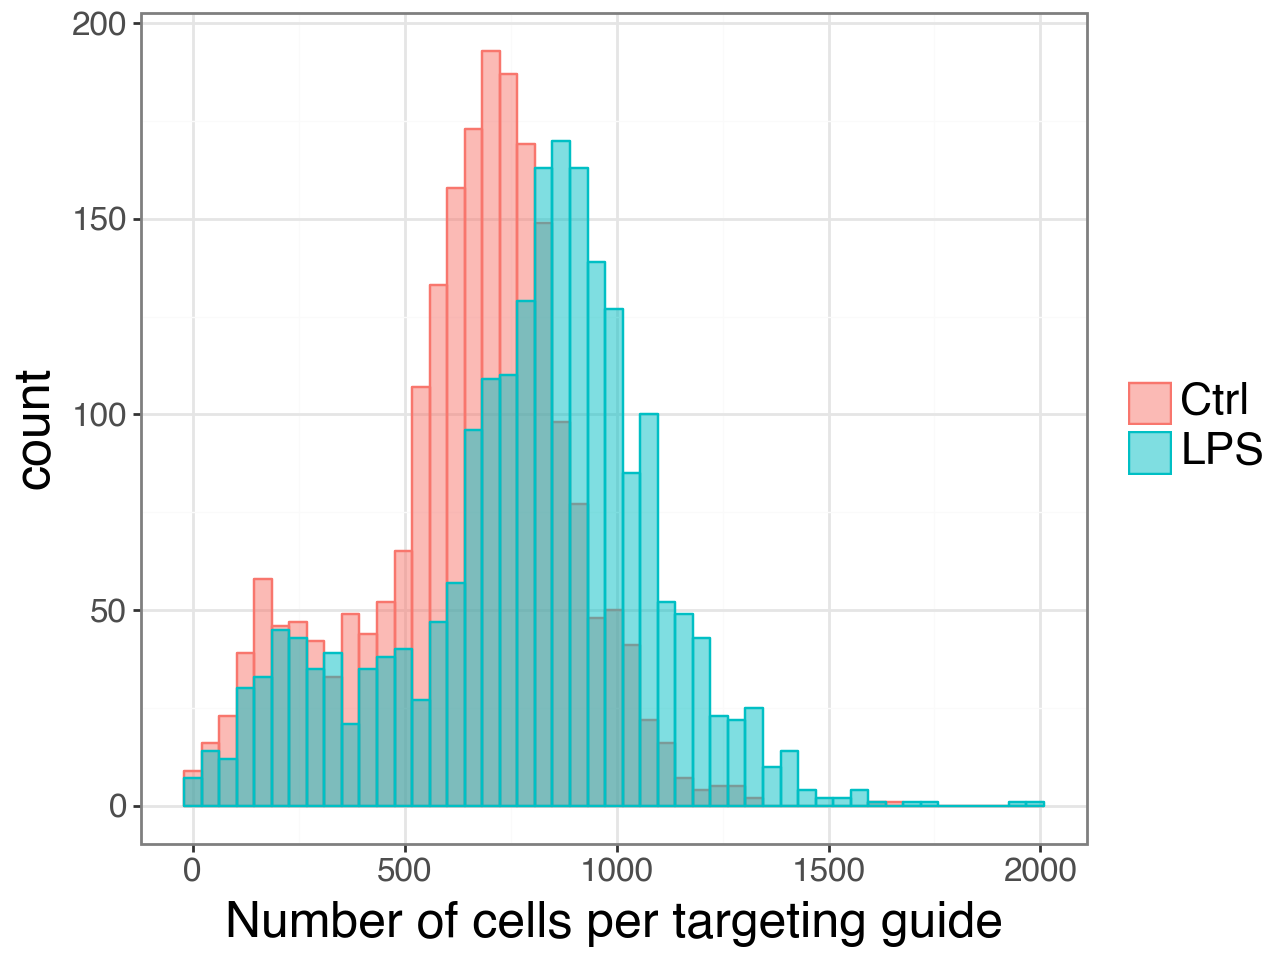

In [39]:
p = (
    ggplot(df, aes(x='n_cells', color='type', fill="type")) 
    + geom_histogram( alpha=0.5, position="identity")
    + labs(x = 'Number of cells per targeting guide')
    + theme_bw()
    + theme(
            legend_title=element_blank(),
            legend_text = element_text(size = 16)
        )
    + theme(
            plot_title = element_text(size = 16, face = "bold"),
            axis_title_x = element_text(size = 18),
            axis_title_y = element_text(size = 18),
            axis_text_x = element_text(size = 12), # Size of tick labels
            axis_text_y = element_text(size = 12)  # Size of tick labels
              )
        
)
p.save(os.path.join(plt_path, 'distribution_of_cell_counts_per_guide.png'), dpi= 150)
p.show()

In [40]:
df_sg = df[df['signif_knockdown']!= False]
df_sg

,guide_id,n_cells,percent_cells_signi_ko,signif_knockdown,type
0,A4GALT-1,684,76.315789,True,LPS
3,A4GALT-4,1135,75.594714,True,LPS
4,AAGAB-1,893,46.024636,True,LPS
5,AAGAB-2,1134,49.911817,True,LPS
6,AAGAB-3,346,40.462428,True,LPS
...,...,...,...,...,...
2153,ZNF384-1,541,60.628466,True,Ctrl
2154,ZNF384-2,631,57.844691,True,Ctrl
2155,ZNF384-3,594,57.575758,True,Ctrl
2156,ZNF384-4,697,56.814921,True,Ctrl


/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/percent_cell_contributor_ko.png
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


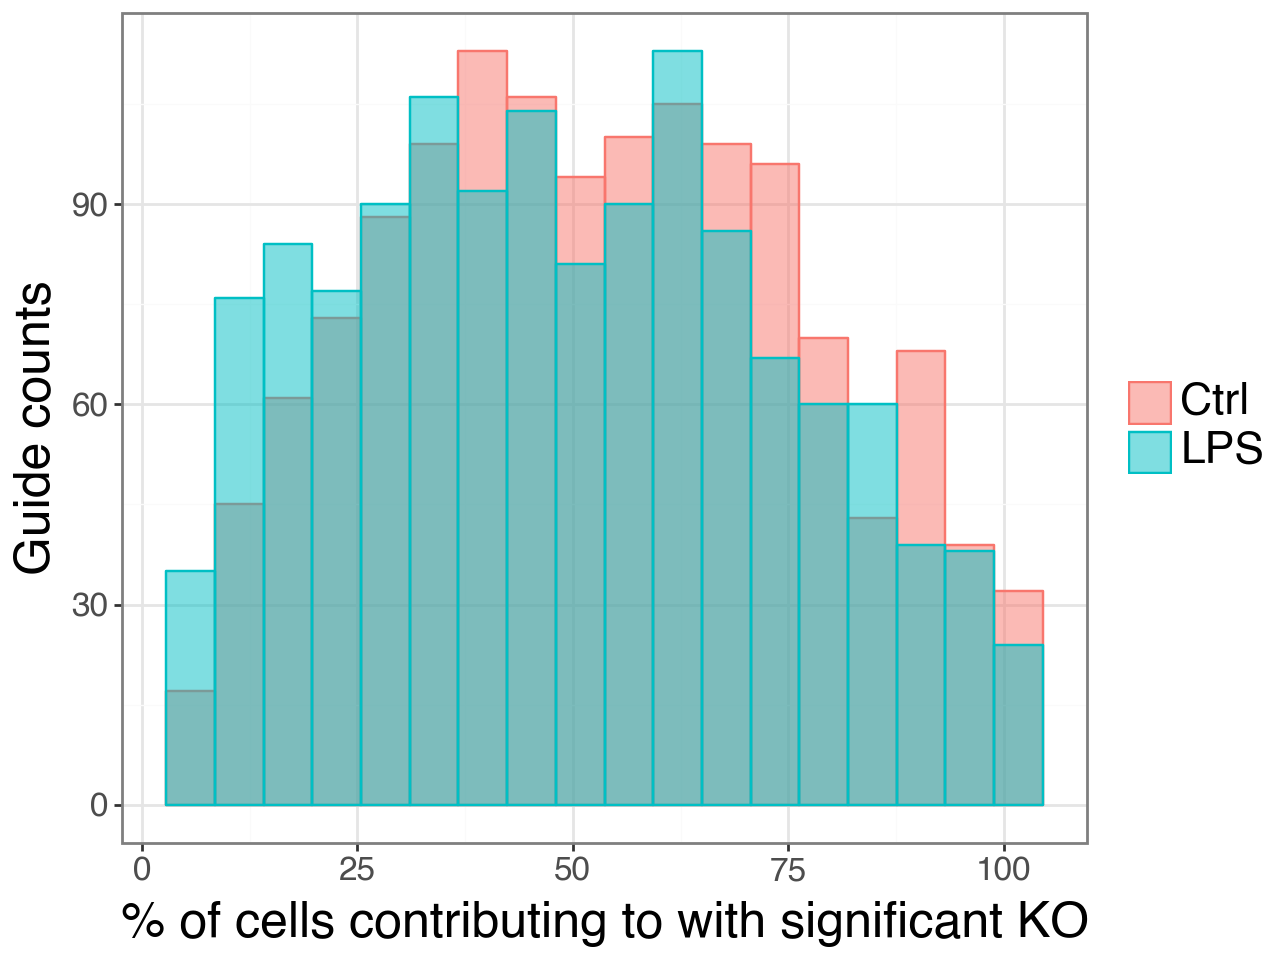

In [41]:
p = (
    ggplot(df_sg, aes(x='percent_cells_signi_ko', color='type', fill="type")) 
    + geom_histogram( alpha=0.5, position="identity")
    + labs(x = '% of cells contributing to with significant KO',
          y = 'Guide counts')
    + theme_bw()
    + theme(
            legend_title=element_blank(),
            legend_text = element_text(size = 16)
        )
    + theme(
            plot_title = element_text(size = 16, face = "bold"),
            axis_title_x = element_text(size = 18),
            axis_title_y = element_text(size = 18),
            axis_text_x = element_text(size = 12), # Size of tick labels
            axis_text_y = element_text(size = 12)  # Size of tick labels
              )
        
)
p.save(os.path.join(plt_path, 'percent_cell_contributor_ko.png'), dpi= 150)
p.show()